### Bibliotecas

In [6]:
import time
import pandas as pd
import numpy as np
from tqdm import tqdm #loop melhor 
import re
import os


import nltk
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
from nltk.stem import LancasterStemmer
from nltk.corpus import stopwords



# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models.ldamulticore import LdaMulticore
from gensim.parsing.preprocessing import STOPWORDS


# Wordcloud
from wordcloud import WordCloud

In [7]:
# Importando base de dados
#%%time
teste = pd.read_csv('Valor_Scrap.csv')

In [8]:
teste

,Data,Título,Texto,Url
0,2011-07-25 10:20:00,Focus: mercado aponta estabilidade em inflação...,SÃO PAULO - O mercado manteve a proj...,https://valor.globo.com/brasil/noticia/2011/07...
1,2011-07-25 10:30:00,Bolsas da Europa caem; dívida dos EUA e rating...,SÃO PAULO - Os investidores nas bols...,https://valor.globo.com/financas/noticia/2011/...
2,2011-07-25 11:00:00,"Seis meses depois, Furnas só trocou de presidente",SÃO PAULO - Símbolo das mudanças que...,https://valor.globo.com/politica/noticia/2011/...
3,2011-07-25 11:10:00,Lupatech fecha contratos para plataformas de p...,"SÃO PAULO - A Lupatech S.A, especial...",https://valor.globo.com/empresas/noticia/2011/...
4,2011-07-25 14:04:00,Homem que confessou massacre na Noruega ficará...,ÃO PAULO – O juiz Kim Heger determin...,https://valor.globo.com/mundo/noticia/2011/07/...
...,...,...,...,...
678611,2022-12-31 19:28:00,"Cláudio Castro, que apoiou Bolsonaro, será o ú...","O governador do Rio, Cláudio Castro ...",https://valor.globo.com/politica/noticia/2022/...
678612,2022-12-31 19:37:00,Lula ainda não decidiu sobre desfile em carro ...,Futuro ministro da Comunicação Socia...,https://valor.globo.com/politica/noticia/2022/...
678613,2022-12-31 19:51:00,Lula conversa com autoridades da Ucrânia e Rús...,O presidente eleito Luiz Inácio Lula...,https://valor.globo.com/politica/noticia/2022/...
678614,2022-12-31 20:23:00,MEC publica portaria regulamentando cursos de ...,O Ministério da Educação (MEC) acaba...,https://valor.globo.com/empresas/noticia/2022/...


##  Passo 1 - Encontrando o primeiro parágrafo de cada notícia

In [45]:
# Tirando os espaços antes de começar a primeira palavra da notícia
teste['Texto'] = teste['Texto'].str.replace(r'^\s+', '', regex=True)

In [60]:
%%time
## Obtendo o primeiro parágrafo (PP) das notícias
# Função para obter o texto até o primeiro espaço duplo ou maior 
def obter_texto(texto):
    padrao = r'\s{2,}'  # expressão regular para encontrar espaço duplo ou maior
    primeiro_espaco_duplo = re.search(padrao, texto)  # encontrar o primeiro espaço duplo ou maior
    if primeiro_espaco_duplo:
        return texto.split(primeiro_espaco_duplo.group(0))[0]  # obter o texto até o primeiro espaço duplo ou maior
    else:
        return texto

teste['PP'] = teste['Texto'].apply(obter_texto) 

Wall time: 9.41 s


#### PP - Primeiro Parágrago   ;   Texto - Notícia completa

In [67]:
teste.head()

,Data,Título,Texto,Url,PP
0,2011-07-25 10:20:00,Focus: mercado aponta estabilidade em inflação...,SÃO PAULO - O mercado manteve a projeção de in...,https://valor.globo.com/brasil/noticia/2011/07...,SÃO PAULO - O mercado manteve a projeção de in...
1,2011-07-25 10:30:00,Bolsas da Europa caem; dívida dos EUA e rating...,SÃO PAULO - Os investidores nas bolsas da Euro...,https://valor.globo.com/financas/noticia/2011/...,SÃO PAULO - Os investidores nas bolsas da Euro...
2,2011-07-25 11:00:00,"Seis meses depois, Furnas só trocou de presidente",SÃO PAULO - Símbolo das mudanças que a preside...,https://valor.globo.com/politica/noticia/2011/...,SÃO PAULO - Símbolo das mudanças que a preside...
3,2011-07-25 11:10:00,Lupatech fecha contratos para plataformas de p...,"SÃO PAULO - A Lupatech S.A, especializada em p...",https://valor.globo.com/empresas/noticia/2011/...,"SÃO PAULO - A Lupatech S.A, especializada em p..."
4,2011-07-25 14:04:00,Homem que confessou massacre na Noruega ficará...,ÃO PAULO – O juiz Kim Heger determinou que And...,https://valor.globo.com/mundo/noticia/2011/07/...,ÃO PAULO – O juiz Kim Heger determinou que And...


### Exemplo:

In [72]:
### Exemplo ###
print(teste.iloc[90,3])
print(teste.iloc[90,2])

https://valor.globo.com/coluna/ministras-passam-no-teste-do-primeiro-mes.ghtml
Uma atravessou o momento mais agudo da crise do PR sem danos à base governista. A outra impôs-se prometendo só o que pode cumprir. Faz pouco mais de um mês que as ministras Ideli Salvatti (Relações Institucionais) e Gleisi Hoffman (Casa Civil) começaram a trabalhar juntas no triunvirato de poder que passaram a compor com a presidente Dilma Rousseff. Impuseram a uma base aliada até então incrédula a sua capacidade de gestão do núcleo de governo.      Ideli voltará a ser testada com o fim do recesso pela pressão em torno das emendas parlamentares e cargos, além das armadilhas fiscais da pauta legislativa. Para dar conta dessa interlocução, além dos despachos diários com a presidente, Ideli fortaleceu laços com o meio político com gestos singelos como a consulta matinal à lista de aniversariantes de ministros, congressistas, governadores e prefeitos.     Os políticos que se reuniram com Gleisi nos últimos dias 

In [73]:
### Exemplo - Primeiro Parágrafo ### 
print(teste.iloc[90,4])

Uma atravessou o momento mais agudo da crise do PR sem danos à base governista. A outra impôs-se prometendo só o que pode cumprir. Faz pouco mais de um mês que as ministras Ideli Salvatti (Relações Institucionais) e Gleisi Hoffman (Casa Civil) começaram a trabalhar juntas no triunvirato de poder que passaram a compor com a presidente Dilma Rousseff. Impuseram a uma base aliada até então incrédula a sua capacidade de gestão do núcleo de governo.


## Passo 2 - Realizando as modificações em toda a base (Título, Notícia e Primeiro Parágrafo) 
#### 1) Tirar pontuações
#### 2) Colocar tudo em letra minúscula 
#### 3) Retirar espaços duplos que vão aparecer após a retirada de pontuações



In [74]:
base = teste

In [78]:
%%time 

# Remover pontuações
def remove_punct(text):
    """Remove pontuações do texto"""
    return re.sub(r'[^\w\s]', '', text)

colunas = ['Título', 'Texto', 'PP']
for j in tqdm(colunas):
    ## Colocando os textos em formato de string 
    base[f'{j}'] = base[f'{j}'].astype(str)
    
    ### Tirando as pontuações
    ## Deleto as pontuações e colocamos '' no lugar - apagando as pontuações e criando uma nova coluna com o texto tratado
    base[f'{j}'] = base[f'{j}'].map(lambda x: re.sub('[,\.!?-]', ' ', x))
    
    # Colocando o texto em letras minúsculas
    base[f'{j}'] = base[f'{j}'].map(lambda x: x.lower())
    
    # Remover pontuações + uma vez
    base[f'{j}'] = base[f'{j}'].apply(remove_punct)
    
    # Tirando os espaços
    base[f'{j}'] = base[f'{j}'].replace(r'\s+', ' ', regex=True)



100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [04:45<00:00, 95.07s/it]

Wall time: 4min 45s



## Passo 3 - Calcular média de palavras

In [81]:
import matplotlib.pyplot as plt

In [86]:
%%time

# criar uma nova coluna contendo o número de palavras em cada linha
base['num_palavras_título'] = base['Título'].apply(lambda x: len(x.split()))

base['num_palavras_texto'] = base['Texto'].apply(lambda x: len(x.split()))

base['num_palavras_pp'] = base['PP'].apply(lambda x: len(x.split()))

Wall time: 29.9 s


In [87]:
base.head()

,Data,Título,Texto,PP,num_palavras_título,num_palavras_texto,num_palavras_pp
0,2011-07-25 10:20:00,focus mercado aponta estabilidade em inflação ...,são paulo o mercado manteve a projeção de infl...,são paulo o mercado manteve a projeção de infl...,8,287,37
1,2011-07-25 10:30:00,bolsas da europa caem dívida dos eua e rating ...,são paulo os investidores nas bolsas da europa...,são paulo os investidores nas bolsas da europa...,12,189,183
2,2011-07-25 11:00:00,seis meses depois furnas só trocou de presidente,são paulo símbolo das mudanças que a president...,são paulo símbolo das mudanças que a president...,8,1073,184
3,2011-07-25 11:10:00,lupatech fecha contratos para plataformas de p...,são paulo a lupatech s a especializada em prod...,são paulo a lupatech s a especializada em prod...,11,162,43
4,2011-07-25 14:04:00,homem que confessou massacre na noruega ficará...,ão paulo o juiz kim heger determinou que ander...,ão paulo o juiz kim heger determinou que ander...,11,143,41


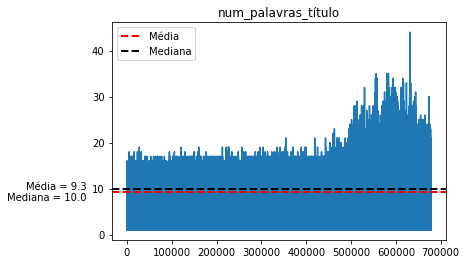

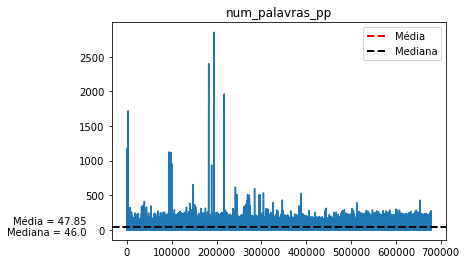

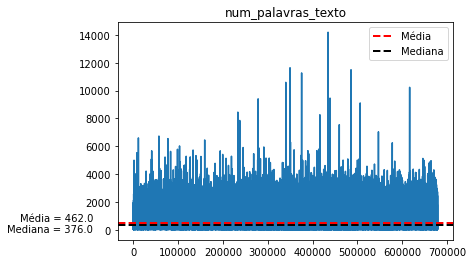

In [122]:
colunas = ['num_palavras_título', 'num_palavras_pp', 'num_palavras_texto']
for j in colunas:

    plt.plot(base[f'{j}'])
    mean = round(base[f'{j}'].mean(),2)
    med = base[f'{j}'].median()
    max = base[f'{j}'].max()
    # adicionar a média e a mediana ao gráfico
    plt.axhline(mean, color='red', linestyle='dashed', linewidth=2, label='Média')
    plt.axhline(med, color='black', linestyle='dashed', linewidth=2, label='Mediana')
    plt.title(f'{j}')
    #plt.text(0.5, base[f'{j}'].mean(), ha='center', va='center', fontsize=12, color='white')
    plt.annotate('Média = {}\nMediana = {}'.format(mean,med), xy=(0.05, mean), xytext=(-40, 0),  textcoords="offset points", ha="right", va="center")
    plt.legend()
    plt.show()

Média de palavras para título, primeiro parágrafo(PP) e notícia "completa" - com **STOPWORDS**

## Passo 4 - Retirar Números e StopWords

### Números

In [136]:
### Retirando Números + Manter SP+RJ ###

colunas = ['Título', 'Texto', 'PP']
for j in tqdm(colunas): 
    base[f'{j}'] = base[f'{j}'].replace(to_replace=r'\d', value='', regex=True)
    base[f'{j}'] = base[f'{j}'].str.replace('são paulo', 'são_paulo')
    base[f'{j}'] = base[f'{j}'].str.replace('rio de janeiro', 'rio_de_janeiro')

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:34<00:00, 11.48s/it]


### StopWords - Parte 1

In [189]:
nltk.download('stopwords')
stop_words = stopwords.words('portuguese')
stop_words.extend(['reuters','valor', 'foto', 'foto:', 'reprodução'])


# Parte 1 - Retirando mais algumas palavras
stop_words.extend(['de','a','o','que','e','do','da','em','um','para','e','com','nao','uma','os','no','se','na','por','mais','as','dos','como','mas','foi',
                   'ao','ele','das','tem','a','seu','sua','ou','ser','quando','muito','ha','nos','ja','esta','eu','tambem','so','pelo','pela','ate','isso',
                   'ela','entre','era','depois','sem','mesmo','aos','ter','seus','quem','nas','me','esse','eles','estao','voce','tinha','foram','essa','num',
                   'nem','suas','meu','as','minha','tem','numa','pelos','elas','havia','seja','qual','sera','nos','tenho','lhe','deles','essas','esses','pelas',
                   'este','fosse','dele','tu','te','voces','vos','lhes','meus','minhas','teu','tua','teus','tuas','nosso','nossa','nossos','nossas','dela','delas',
                   'esta','estes','estas','aquele','aquela','aqueles','aquelas','isto','aquilo','estou','esta','estamos','estao','estive','esteve','estivemos',
                   'estiveram','estava','estavamos','estavam','estivera','estiveramos','esteja','estejamos','estejam','estivesse','estivessemos','estivessem',
                   'estiver','estivermos','estiverem','hei','ha','havemos','hao','houve','houvemos','houveram','houvera','houveramos','haja','hajamos','hajam',
                   'houvesse','houvessemos','houvessem','houver','houvermos','houverem','houverei','houvera','houveremos','houverao','houveria','houveriamos',
                   'houveriam','sou','somos','era','eramos','eram','fui','foi','fomos','foram','fora','foramos','seja','sejamos','sejam','fosse','fossemos',
                   'fossem','for','formos','forem','serei','sera','seremos','serao','seria','seriamos','seriam','tenho','tem','temos','tem','tinha','tinhamos',
                   'tinham','tive','teve','tivemos','tiveram','tivera','tiveramos','tenha','tenhamos','tenham','tivesse','tivessemos','tivessem','tiver','tivermos',
                   'tiverem','terei','tera','teremos','terao','teria','teriamos','teriam'])

# Parte 2 - Parte anterior com acento
stop_words.extend(['de',  'a',  'o',  'que',  'e',  'do',  'da',  'em',  'um',  'para',  'é',  'com',  'não',  'uma',  'os',  'no',  'se',  'na',  'por',  'mais',  
                    'as',  'dos',  'como',  'mas',  'foi',  'ao',  'ele',  'das',  'tem',  'à',  'seu',  'sua',  'ou',  'ser',  'quando',  'muito',  'há',  'nos',  
                    'já',  'está',  'eu',  'também',  'só',  'pelo',  'pela',  'até',  'isso',  'ela',  'entre',  'era',  'depois',  'sem',  'mesmo',  'aos',  'ter', 
                    'seus',  'quem',  'nas',  'me',  'esse',  'eles',  'estão',  'você',  'tinha',  'foram',  'essa',  'num',  'nem',  'suas',  'meu',  'às',  'minha',
                    'têm',  'numa',  'pelos',  'elas',  'havia',  'seja',  'qual',  'será',  'nós',  'tenho',  'lhe',  'deles',  'essas',  'esses',  'pelas',  'este',  
                    'fosse',  'dele',  'tu',  'te',  'vocês',  'vos',  'lhes',  'meus',  'minhas',  'teu',  'tua',  'teus',  'tuas',  'nosso',  'nossa',  'nossos',  
                    'nossas',  'dela',  'delas',  'esta',  'estes',  'estas',  'aquele',  'aquela',  'aqueles',  'aquelas',  'isto',  'aquilo',  'estou',  'está',  
                    'estamos',  'estão',  'estive',  'esteve',  'estivemos',  'estiveram',  'estava',  'estávamos',  'estavam',  'estivera',  'estivéramos',  'esteja',  
                    'estejamos',  'estejam',  'estivesse',  'estivéssemos',  'estivessem',  'estiver',  'estivermos',  'estiverem',  'hei',  'há',  'havemos',  'hão', 
                    'houve',  'houvemos',  'houveram',  'houvera',  'houvéramos',  'haja',  'hajamos',  'hajam',  'houvesse',  'houvéssemos',  'houvessem',  'houver',  
                    'houvermos',  'houverem',  'houverei',  'houverá',  'houveremos',  'houverão',  'houveria',  'houveríamos',  'houveriam',  'sou',  'somos',  'são', 
                    'era',  'éramos',  'eram',  'fui',  'foi',  'fomos',  'foram',  'fora',  'fôramos',  'seja',  'sejamos',  'sejam',  'fosse',  'fôssemos',  'fossem', 
                    'for',  'formos',  'forem',  'serei',  'será',  'seremos',  'serão',  'seria',  'seríamos',  'seriam',  'tenho',  'tem',  'temos',  'tém',  'tinha',  
                    'tínhamos',  'tinham',  'tive',  'teve',  'tivemos',  'tiveram',  'tivera',  'tivéramos',  'tenha',  'tenhamos',  'tenham',  'tivesse', 
                    'tivéssemos',  'tivessem',  'tiver',  'tivermos',  'tiverem',  'terei',  'terá',  'teremos',  'terão',  'teria',  'teríamos',  'teriam'])

# Parte 2 - Adicionando mais um conjunto de palavras, porém essas palavras possuem acentos.

const_words = [ 'a', 'à', 'adeus', 'agora', 'aí', 'ainda', 'além', 'algo', 'alguém', 'algum', 'alguma', 'algumas', 'alguns', 'ali', 'ampla', 'amplas', 'amplo', 
               'amplos', 'ano', 'anos', 'ante', 'antes', 'ao', 'aos', 'apenas', 'apoio', 'após', 'aquela', 'aquelas', 'aquele', 'aqueles', 'aqui', 'aquilo', 
               'área', 'as', 'às', 'assim', 'até', 'atrás', 'através', 'baixo', 'bastante', 'bem', 'boa', 'boas', 'bom', 'bons', 'breve', 'cá', 'cada', 'catorze',
               'cedo', 'cento', 'certamente', 'certeza', 'cima', 'cinco', 'coisa', 'coisas', 'com', 'como', 'conselho', 'contra', 'contudo', 'custa', 'da', 'dá',
               'dão', 'daquela', 'daquelas', 'daquele', 'daqueles', 'dar', 'das', 'de', 'debaixo', 'dela', 'delas', 'dele', 'deles', 'demais', 'dentro', 'depois', 
               'desde', 'dessa', 'dessas', 'desse', 'desses', 'desta', 'destas', 'deste', 'destes', 'deve', 'devem', 'devendo', 'dever', 'deverá', 'deverão', 'deveria', 
               'deveriam', 'devia', 'deviam', 'dez', 'dezanove', 'dezasseis', 'dezassete', 'dezoito', 'dia', 'diante', 'disse', 'disso', 'disto', 'dito', 'diz', 'dizem', 
               'dizer', 'do', 'dois', 'dos', 'doze', 'duas', 'dúvida', 'e', 'é', 'ela', 'elas', 'ele', 'eles', 'em', 'embora', 'enquanto', 'entre', 'era', 'eram', 'éramos',
               'és', 'essa', 'essas', 'esse', 'esses', 'esta', 'está', 'estamos', 'estão', 'estar', 'estas', 'estás', 'estava', 'estavam', 'estávamos', 'este', 'esteja', 
               'estejam', 'estejamos', 'estes', 'esteve', 'estive', 'estivemos', 'estiver', 'estivera', 'estiveram', 'estivéramos', 'estiverem', 'estivermos', 'estivesse', 
               'estivessem', 'estivéssemos', 'estiveste', 'estivestes', 'estou', 'etc', 'eu', 'exemplo', 'faço', 'falta', 'favor', 'faz', 'fazeis', 'fazem', 'fazemos',
               'fazendo', 'fazer', 'fazes', 'feita', 'feitas', 'feito', 'feitos', 'fez', 'fim', 'final', 'foi', 'fomos', 'for', 'fora', 'foram', 'fôramos', 'forem', 
               'forma', 'formos', 'fosse', 'fossem', 'fôssemos', 'foste', 'fostes', 'fui', 'geral', 'grande', 'grandes', 'grupo', 'há', 'haja', 'hajam', 'hajamos', 'hão',
               'havemos', 'havia', 'hei', 'hoje', 'hora', 'horas', 'houve', 'houvemos', 'houver', 'houvera', 'houverá', 'houveram', 'houvéramos', 'houverão', 'houverei', 
               'houverem', 'houveremos', 'houveria', 'houveriam', 'houveríamos', 'houvermos', 'houvesse', 'houvessem', 'houvéssemos', 'isso', 'isto', 'já', 'la', 'lá', 
               'lado', 'lhe', 'lhes', 'lo', 'local', 'logo', 'longe', 'lugar', 'maior', 'maioria', 'mais', 'mal', 'mas', 'máximo', 'me', 'meio', 'menor', 'menos', 'mês',
               'meses', 'mesma', 'mesmas', 'mesmo', 'mesmos', 'meu', 'meus', 'mil', 'minha', 'minhas', 'momento', 'muita', 'muitas', 'muito', 'muitos', 'na', 'nada', 'não', 
               'naquela', 'naquelas', 'naquele', 'naqueles', 'nas', 'nem', 'nenhum', 'nenhuma', 'nessa', 'nessas', 'nesse', 'nesses', 'nesta', 'nestas', 'neste', 'nestes', 
               'ninguém', 'nível', 'no', 'noite', 'nome', 'nos', 'nós', 'nossa', 'nossas', 'nosso', 'nossos', 'nova', 'novas', 'nove', 'novo', 'novos', 'num', 'numa', 
               'número', 'nunca', 'o', 'obra', 'obrigada', 'obrigado', 'oitava', 'oitavo', 'oito', 'onde', 'ontem', 'onze', 'os', 'ou', 'outra', 'outras', 'outro', 'outros', 
               'para', 'parece', 'parte', 'partir', 'paucas', 'pela', 'pelas', 'pelo', 'pelos', 'pequena', 'pequenas', 'pequeno', 'pequenos', 'per', 'perante', 'perto', 
               'pode', 'pude', 'pôde', 'podem', 'podendo', 'poder', 'poderia', 'poderiam', 'podia', 'podiam', 'põe', 'põem', 'pois', 'ponto', 'pontos', 'por', 'porém',
               'porque', 'porquê', 'posição', 'possível', 'possivelmente', 'posso', 'pouca', 'poucas', 'pouco', 'poucos', 'primeira', 'primeiras', 'primeiro', 'primeiros',
               'própria', 'próprias', 'próprio', 'próprios', 'próxima', 'próximas', 'próximo', 'próximos', 'pude', 'puderam', 'quais', 'quáis', 'qual', 'quando', 'quanto', 
               'quantos', 'quarta', 'quarto', 'quatro', 'que', 'quê', 'quem', 'quer', 'quereis', 'querem', 'queremas', 'queres', 'quero', 'questão', 'quinta', 'quinto',
               'quinze', 'relação', 'sabe', 'sabem', 'se', 'segunda', 'segundo', 'sei', 'seis', 'seja', 'sejam', 'sejamos', 'sem', 'sempre', 'sendo', 'ser', 'será', 
               'serão', 'serei', 'seremos', 'seria', 'seriam', 'seríamos', 'sete', 'sétima', 'sétimo', 'seu', 'seus', 'sexta', 'sexto', 'si', 'sido', 'sim', 'sistema', 
               'só', 'sob', 'sobre', 'sois', 'somos', 'sou', 'sua', 'suas', 'tal', 'talvez', 'também', 'tampouco', 'tanta', 'tantas', 'tanto', 'tão', 'tarde', 'te', 'tem',
               'tém', 'têm', ' só ', 'temos', 'tendes', 'tendo', 'tenha', 'tenham', 'tenhamos', 'tenho', 'tens', 'ter', 'terá', 'terão', 'terceira', 'terceiro', 'terei', 'teremos',
               'teria', 'teriam', 'teríamos', 'teu', 'teus', 'teve', 'ti', 'tido', 'tinha', 'tinham', 'tínhamos', 'tive', 'tivemos', 'tiver', 'tivera', 'tiveram', 'tivéramos', 
               'tiverem', 'tivermos', 'tivesse', 'tivessem', 'tivéssemos', 'tiveste', 'tivestes', 'toda', 'todas', 'todavia', 'todo', 'todos', 'trabalho', 'três', 'treze', 
               'tu', 'tua', 'tuas', 'tudo', 'última', 'últimas', 'último', 'últimos', 'um', 'uma', 'umas', 'uns', 'vai', 'vais', 'vão', 'vários', 'vem', 'vêm', 'vendo',
               'vens', 'ver', 'vez', 'vezes', 'viagem', 'vindo', 'vinte', 'vir', 'você', 'vocês', 'vos', 'vós', 'vossa', 'vossas', 'vosso', 'vossos', 'zero']
stop_words.extend(const_words)

# Parte 3 - Algumas outras
stop_words.extend(['durante', 'pessoa', 'pergunte', 'perguntei', 'perguntando', 'pergunta','caso', 'sentido', 'deu', 'somente'])


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gcard\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [190]:
# função para remover palavras da lista
def remove_words(text, remove_list):
    return ' '.join([word for word in text.split() if word not in remove_list])

In [191]:
%%time

# Retirando as stopwords de cada uma das colunas
colunas = ['Título', 'Texto', 'PP']
for j in tqdm(colunas): 
    base[f'{j}'] = base[f'{j}'].apply(lambda x: remove_words(x, stop_words))


100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [43:59<00:00, 879.90s/it]

Wall time: 43min 59s


### StopWords - Parte 2

Foi obersado que **143** notícias estão em inglês.

*base[base['Texto'].str.startswith('the')]*

Vamos utilizar uma pequena lista de stopwords em inglês, já que 143 é um número baixo.

Fonte: Está nos comentários de https://gist.github.com/sebleier/554280

In [321]:
%%time

## Outro conjunto de stopwords em pt-br
stop_words2 = ['apesar', 'vamos']


# StopWords em Inglês
stop_words2.extend(["me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", 
                    "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", 
                    "hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs", 
                    "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", 
                    "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", 
                    "having", "do", "does", "did", "doing", "an", "the", "and", "but", "if", 
                    "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", 
                    "about", "against", "between", "into", "through", "during", "before", "after", 
                    "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", 
                    "under", "again", "further", "then", "once", "here", "there", "when", "where",
                    "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", 
                    "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", 
                    "very", "can", "will", "just", "don", "should", "now"])


# Retirando as stopwords2 de cada uma das colunas
colunas = ['Título', 'Texto', 'PP']
for j in tqdm(colunas): 
    base[f'{j}'] = base[f'{j}'].apply(lambda x: remove_words(x, stop_words2))




100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [06:05<00:00, 121.68s/it]

Wall time: 6min 5s


In [340]:
# Tirando os espaços duplos

colunas = ['Título', 'Texto', 'PP']
for j in tqdm(colunas):      
    base[f'{j}'] = base[f'{j}'].replace(r'\s+', ' ', regex=True)

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:27<00:00, 29.21s/it]


### Remover palavras com 1 letra e outras pontuações

In [316]:
def remove_one_letter_words(text):
    return re.sub(r'\b\w{1}\b', '', text)

colunas = ['Título', 'Texto', 'PP']
for j in tqdm(colunas): 
    ## Retirando outras pontuações que ainda estavam no texto
    base[f'{j}'] = base[f'{j}'].apply(lambda x: re.sub('[ºª°]', '', x))
    ## Retirando palavras com uma letra
    base[f'{j}'] = base[f'{j}'].apply(remove_one_letter_words)


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:03<00:00, 21.25s/it]


### Contagem de palavras após retirada de números e stopwords

In [341]:
%%time

# criar uma nova coluna contendo o número de palavras em cada linha - Após retirada de números e stopwords
base['num_palavras_título2'] = base['Título'].apply(lambda x: len(x.split()))

base['num_palavras_texto2'] = base['Texto'].apply(lambda x: len(x.split()))

base['num_palavras_pp2'] = base['PP'].apply(lambda x: len(x.split()))

Wall time: 15.7 s
Compiler : 110 ms


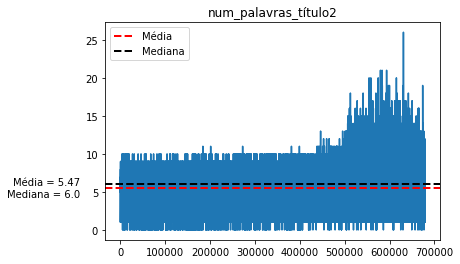

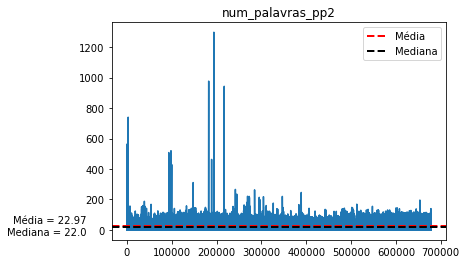

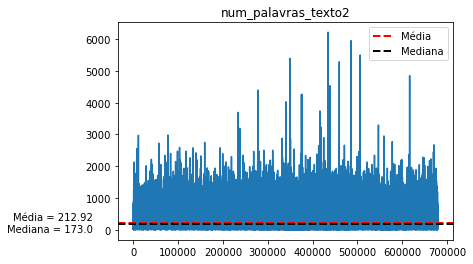

In [342]:
colunas = ['num_palavras_título2', 'num_palavras_pp2', 'num_palavras_texto2']
for j in colunas:

    plt.plot(base[f'{j}'])
    mean = round(base[f'{j}'].mean(),2)
    med = base[f'{j}'].median()
    max = base[f'{j}'].max()
    # adicionar a média e a mediana ao gráfico
    plt.axhline(mean, color='red', linestyle='dashed', linewidth=2, label='Média')
    plt.axhline(med, color='black', linestyle='dashed', linewidth=2, label='Mediana')
    plt.title(f'{j}')
    #plt.text(0.5, base[f'{j}'].mean(), ha='center', va='center', fontsize=12, color='white')
    plt.annotate('Média = {}\nMediana = {}'.format(mean,med), xy=(0.05, mean), xytext=(-40, 0),  textcoords="offset points", ha="right", va="center")
    plt.legend()
    plt.show()

In [343]:
base.head(3)

,Data,Título,Texto,PP,num_palavras_título,num_palavras_texto,num_palavras_pp,num_palavras_título2,num_palavras_texto2,num_palavras_pp2,texto,pp
0,2011-07-25 10:20:00,focus mercado aponta estabilidade inflação,são_paulo mercado manteve projeção inflação me...,são_paulo mercado manteve projeção inflação me...,8,287,37,5,124,19,mercado manteve projeção inflação medida índic...,mercado manteve projeção inflação medida índic...
1,2011-07-25 10:30:00,bolsas europa caem dívida eua rating grécia pr...,são_paulo investidores bolsas europa mostram c...,são_paulo investidores bolsas europa mostram c...,12,189,183,8,79,75,investidores bolsas europa mostram cautelosos ...,investidores bolsas europa mostram cautelosos ...
2,2011-07-25 11:00:00,furnas trocou presidente,são_paulo símbolo mudanças presidente dilma ro...,são_paulo símbolo mudanças presidente dilma ro...,8,1073,184,3,543,95,símbolo mudanças presidente dilma rousseff pre...,símbolo mudanças presidente dilma rousseff pre...


## Passo 5 - Retirando Cidades

No início das notícias, aparecem várias cidades como se fosse o "local" de publicação da notícia.


### Exemplo:

In [348]:
base.iloc[2,3]

'são_paulo símbolo mudanças presidente dilma rousseff pretendia eletrobras furnas estatal orçamento setor bilhões segue posse quase intacta queda braço pmdb dilma tirou presidente estatal carlos nadalutti apadrinhado deputado federal eduardo cunha rj vice líder partido câmara manteve intactas diretorias funcionário carreira estatal nadalutti demitido presidente flávio decat abrigou assessor gabinete expectativas mudança alimentadas carta divulgada janeiro funcionários furnas furnas passa maiores crises história teme futuro empregados preocupados futuro empresa apostam intervenção presidente dilma dizia manifesto prosseguia listando loteamento político estatal prejuízos erário decorrente avaliação interna decat autonomia trocar cúpula empresa superintendentes diretores companhia assumiu fevereiro'

In [347]:
termos = ['são_paulo', 'rio_de_janeiro', 'brasília']
lista = []

for termo in termos:
    x = base['Título'].str.count(f'{termo}').sum()
    y = base['PP'].str.count(f'{termo}').sum()
    z = base['Texto'].str.count(f'{termo}').sum()
    lista.append([termo, x,y,z])
    
ob = pd.DataFrame(lista)
ob

,0,1,2,3
0,são_paulo,3845,55213,223691
1,rio_de_janeiro,302,10455,61366
2,brasília,997,13446,55805


Note que **são paulo** aparece **3.845** vezes no título, **55.213** vezes no primeiro parágrafo e **223.691** vezes nas notícias inteiras. Esse alto número pode ser ocasionado por esse tipo de situação, como visto no exemplo anterior em que o primeiro termo da notícia é **são paulo**.

In [352]:
base['pp'] = base['PP'].str.replace(r'^(são_paulo)\s+', '', regex=True)
base['pp'].str.count('são_paulo').sum()

33025

Foi retirado todos os termos **são paulo** que aparecem somente na primeira palavra do primeiro parágrafo ou texto. Se esse termo aparecer ao longo da notícia, esses outros vão continuar. O úncio que vai ser retirado é o que está na posição inicial. Houve uma redução de **22.000**. 

Portanto, vamos retirar as "principais cidades" que aparecem nessa posição inicial, como rio de janeiro, washigton, brasília,...

In [364]:
base['pp'] = base['PP'].str.replace(r'^(são_paulo)\s+', '', regex=True)

In [424]:
%%time

# capitais brasileiras e principais capitais financeiras do mundo 
termos = ['são_paulo', 'rio_de_janeiro', 'madri', 'santos', 'belo horizonte', 'genebra', 'washington', 'londres', 'york',
         'bruxelas', 'frankfurt', 'brasília', 'paris', 'buenos aires', 'los angeles', 'ão paulo', 'salvador', 'recife',
          'campinas', 'porto alegre', 'curitiba', 'recife', 'fortaleza', 'belém', 'manaus', 'goiânia', 'joão pessoa',
         'aracaju', 'natal', 'florianópolis', 'campo grande', 'cuiabá', 'teresina', 'são luís', 'palmas', 'macapá', 
         'porto velho', 'rio branco', 'hong kong', 'tóquio', 'singapura', 'sydney', 'zurique', 'toronto','amsterdã',
         'xangai', 'dubai', 'mumbai', 'pequim', 'seul', 'são francisco', 'chicago', 'boston', 'milão','luxemburgo',
         'dublin', 'viena', 'copenhague', 'estocolmo', 'helsinque','manila', 'kuala lumpur']


for termo in tqdm(termos):
    base['pp'] = base['pp'].str.replace(rf'^({termo})\s+', '', regex=True)
    base['texto'] = base['texto'].str.replace(rf'^({termo})\s+', '', regex=True)


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [17:59<00:00, 17.41s/it]

Wall time: 17min 59s
Compiler : 454 ms


In [425]:
base['pp'].head()

0    mercado manteve projeção inflação medida índic...
1    investidores bolsas europa mostram cautelosos ...
2    símbolo mudanças presidente dilma rousseff pre...
3    lupatech especializada produtos serviços setor...
4    juiz kim heger determinou anders behring breiv...
Name: pp, dtype: object

In [426]:
termos = ['são_paulo', 'rio_de_janeiro', 'madri', 'santos', 'belo horizonte', 'genebra', 'washington', 'londres', 'york',
         'bruxelas', 'frankfurt', 'brasília', 'paris', 'buenos aires', 'los angeles', 'ão paulo']

lista = []

for termo in termos:
    x = base['Título'].str.count(f'{termo}').sum()
    y = base['pp'].str.count(f'{termo}').sum()
    z = base['texto'].str.count(f'{termo}').sum()
    lista.append([termo, x,y,z])
    
ob2 = pd.DataFrame(lista)
ob2.head()

,0,1,2,3
0,são_paulo,3845,33009,201220
1,rio_de_janeiro,302,10350,61258
2,madri,148,631,6510
3,santos,1239,4395,37452
4,belo horizonte,216,1586,13978


## Contagem de palavras após a retirada das principais cidades do início da notícia

In [427]:
%%time

# criar uma nova coluna contendo o número de palavras em cada linha - Após retirada das cidades inciais
base['num_palavras_título3'] = base['Título'].apply(lambda x: len(x.split()))

base['num_palavras_texto3'] = base['texto'].apply(lambda x: len(x.split()))

base['num_palavras_pp3'] = base['pp'].apply(lambda x: len(x.split()))

Wall time: 16.3 s
Compiler : 355 ms


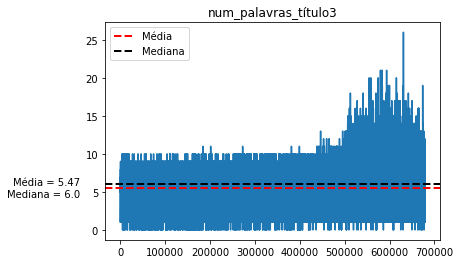

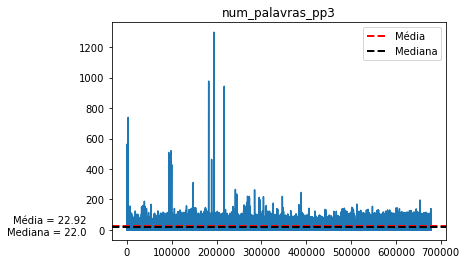

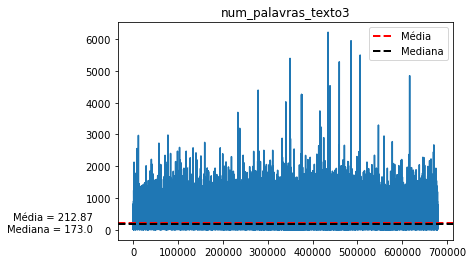

In [428]:
colunas = ['num_palavras_título3', 'num_palavras_pp3', 'num_palavras_texto3']
for j in colunas:

    plt.plot(base[f'{j}'])
    mean = round(base[f'{j}'].mean(),2)
    med = base[f'{j}'].median()
    max = base[f'{j}'].max()
    # adicionar a média e a mediana ao gráfico
    plt.axhline(mean, color='red', linestyle='dashed', linewidth=2, label='Média')
    plt.axhline(med, color='black', linestyle='dashed', linewidth=2, label='Mediana')
    plt.title(f'{j}')
    #plt.text(0.5, base[f'{j}'].mean(), ha='center', va='center', fontsize=12, color='white')
    plt.annotate('Média = {}\nMediana = {}'.format(mean,med), xy=(0.05, mean), xytext=(-40, 0),  textcoords="offset points", ha="right", va="center")
    plt.legend()
    plt.show()

## Título + Primeiro Parágrafo? Quantas palavras do primeiro parágrafo?

In [442]:
# Número total de notícias
len(base['num_palavras_pp3'])

678616

### 5% - 33.930 notícias

95% das notícias possuem menos do que 45 palavras

In [502]:
# Pegando a quantidade de palavras que possui no primeiro parágrafo. 
# 45 é o menor número de palavras que as 33930 (5% das notícias totais) possuem 
base['num_palavras_pp3'].nlargest(33930).tail()

587490    45
588015    45
588407    45
588509    45
589422    45
Name: num_palavras_pp3, dtype: int64

### 10% - 67.862 notícias
90% das notícias possuem menos do que 38 palavras

In [522]:
base['num_palavras_pp3'].nlargest(67862).tail()

109896    38
109952    38
110056    38
110228    38
110466    38
Name: num_palavras_pp3, dtype: int64

### 15% - 101.793 notícias
85% das notícias possuem menos do que 35 palavras

In [536]:
base['num_palavras_pp3'].nlargest(101793).tail()

530140    35
530158    35
530183    35
530210    35
530224    35
Name: num_palavras_pp3, dtype: int64

### 20% - 135.724 notícias
80% das notícias possuem menos do que 32 palavras

45% das notícias possuem menos do que 21 palavras

In [552]:
base['num_palavras_pp3'].nlargest(135724).tail()

317772    32
317776    32
318031    32
318058    32
318151    32
Name: num_palavras_pp3, dtype: int64

# BASE

Vamos selecionar as 40 primeiras palavras de cada primeiro parágrafo da notícia

In [597]:
# Selecionar as 40 primeiras palavras de cada notícias
base['primeiras_palavras'] = base['pp'].str.split().str[:40].str.join(' ')

In [605]:
# Concatenar duas colunas 
base = base.assign(merge=base['Título'].str.cat(base['primeiras_palavras'], sep=' '))  

In [617]:
base.to_csv('Análise_Número_Palavras_Completa.csv', index=False)

In [618]:
base_final = base.loc[:, ['Data', 'merge']]

In [619]:
base_final.head()

,Data,merge
0,2011-07-25 10:20:00,focus mercado aponta estabilidade inflação mer...
1,2011-07-25 10:30:00,bolsas europa caem dívida eua rating grécia pr...
2,2011-07-25 11:00:00,furnas trocou presidente símbolo mudanças pres...
3,2011-07-25 11:10:00,lupatech fecha contratos plataformas produção ...
4,2011-07-25 14:04:00,homem confessou massacre noruega ficará detido...


In [620]:
base_final.to_csv('Base_Final_PP.csv', index=False)

Utilizando todas as palavras do primeiro parágrafo

In [621]:
# Concatenar duas colunas 
base = base.assign(total=base['Título'].str.cat(base['pp'], sep=' '))  

In [622]:
base_final_total = base.loc[:, ['Data', 'total']]

In [623]:
base_final_total.to_csv('Base_Final_PP.csv', index=False)

## Trainamento - Dados até 31/12/2020

In [632]:
len(base[~(base['Data'] > '2020-31-12')])

542248

In [633]:
len(base['Data'])

678616

In [634]:
# Utilizando 80% da base como treinamento
(542248/678616)*100

79.90498308321644